# Figure 9, Supplement 5- Poke Timing


In [1]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

# Data Load


In [2]:
pdf = u.load_poke_df()
pdf = u.compute_days_relative_to_stage(pdf, 5)
pdf["days_relative_to_stage_5_adj"] = pdf["days_relative_to_stage_5"].astype(int) + 1
g_pdf = pdf.query("stage in @c.GROWING_STAGES").copy()
pr_pdf = pdf.query("stage in @c.PROBE_STAGES").copy()

Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


In [3]:
## 7 Days of Growth
g_pdf_7d = g_pdf.query("days_relative_to_stage_5_adj <= 7").copy()
valid_g_pdf_7d = g_pdf_7d.query("was_valid == True").copy()
violation_g_pdf_7d = g_pdf_7d.query("was_valid == False").copy()

### No Warm Up
no_warm_up_g_pdf_7d_v1 = g_pdf_7d.query(
    "fix_experiment == 'V1' and fixation_dur < 2 and trial > 20"
)

no_warm_up_g_pdf_7d = pd.concat([no_warm_up_g_pdf_7d_v1, g_pdf_7d.query("fix_experiment == 'V2'")])

valid_no_warm_up_g_pdf_7d = no_warm_up_g_pdf_7d.query("was_valid == True").copy()
violation_no_warm_up_g_pdf_7d = no_warm_up_g_pdf_7d.query("was_valid == False").copy()                                                                   

## All Growth
valid_g_pdf = g_pdf.query("was_valid == True").copy()
violation_g_pdf = g_pdf.query("was_valid == False").copy()

## Probe
valid_pr_pdf = pr_pdf.query("was_valid == True").copy()
violation_pr_pdf = pr_pdf.query("was_valid == False").copy()

PRE_GO_VIOLATION_WINDOW = 0.2 # used for near-cue violation rate

# Functions


In [4]:
def plot_relative_cpoke_dur_histplot(
    df,
    ax=None,
    xmin=-2.5,
    xmax=2,
    palette=c.VALID_PALETTE,
    ylim=None,
    title=None,
    title_color="k",
    **kwargs,
):
    """
    plot histogram of cpoke timing relative to the go cue for all failed and
    valid cpokes (including settling_in cpokes)

    params
    ------
    df : pd.DataFrame
        dataframe with columns `relative_cpoke_dur`and `was_valid`
        with cpoke as row index
    ax : matplotlib.axes (optional, default = None)
        axis to plot to
    xmin : float (optional, default = -2.5)
        minimum x-axis value to plot
    xmax : float (optional, default = 2)
        maximum x-axis value to plot
    ylim : tuple (optional, default = None)
        y-axis limits to plot
    title : str (optional, default = None)
        title of the plot
    title_color : str (optional, default = "k")
        color of the title
    """

    if xmin:
        df = df.query("relative_cpoke_dur > @xmin")
    if xmax:
        df = df.query("relative_cpoke_dur < @xmax")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    ax.axvspan(0, 0.2, color='gray', alpha=0.1, label="Go Cue")

    sns.histplot(
        data=df,
        x="relative_cpoke_dur",
        hue="was_valid",
        hue_order=[False, True],
        ax=ax,
        palette=palette,
        binwidth=0.025,
        **kwargs,
    
    )

    # plot vertical lines

    avg_failed_dur = df.query("was_valid == False").relative_cpoke_dur.mean()
    # ax.axvline(avg_failed_dur, color=palette[0], lw=2, label="Mean Violation")
    print("Violation Duration Stats")
    std = df.query("was_valid == False").relative_cpoke_dur.std()
    print(f"N violation cpokes: {df.query('was_valid == False').shape[0]}")
    print(f"Mean Violation Duration: {avg_failed_dur:.2f} +/- {std:.2f} std")
    print(
        f"Median Violation Duration: {df.query('was_valid == False').relative_cpoke_dur.median():.2f}"
    )
    median_failed_dur = df.query("was_valid == False").relative_cpoke_dur.median()
    ax.axvline(
        median_failed_dur,
        color=palette[0],
        lw=2,
        ls="--",
        label="Median Violation",
    )

    avg_valid_dur = df.query("was_valid == True").relative_cpoke_dur.mean()
    # ax.axvline(avg_valid_dur, color=palette[1], lw=2, label="Mean Valid ")
    print("\nValid Duration Stats")
    std = df.query("was_valid == True").relative_cpoke_dur.std()
    print(f"N valid cpokes: {df.query('was_valid == True').shape[0]}")
    print(f"Mean Valid Duration: {avg_valid_dur:.2f} +/- {std:.2f} std")
    print(
        f"Median Valid Duration: {df.query('was_valid == True').relative_cpoke_dur.median():.2f}"
    )
    median_valid_dur = df.query("was_valid == True").relative_cpoke_dur.median()
    ax.axvline(median_valid_dur, color=palette[1], lw=2, ls="--", label="Median Valid")

    ax.axvline(0, color="k")
    if title is None:
        failure_rate = df.query("was_valid == False").shape[0] / df.shape[0]
        title = f"Failure_rate {failure_rate:.2f},  Avg Cpoke Dur: {df.cpoke_dur.mean():.2f}"

    ax.legend(title="", loc="upper left", frameon=False)

    # aesthetics
    _ = ax.set(
        xlabel="Cpoke Fixation Duration Relative to Go-Cue (s)",
        ylim=(0, ylim),
        xlim=(xmin, xmax),
        ylabel="N Pokes",
    )
    ax.set_title(title, color=title_color, fontweight="bold")
    plt.tight_layout()

    sns.despine()

    return fig, ax

In [5]:
def plot_exp_compare_point_strip(df, y_col, y_label, y_limits):
    """
    Create a point + strip plot of y_col metric by experiment.

    Parameters
    ----------
    df : pandas.DataFrame
        Input data containing at least 'fix_experiment' and y_col.
    y_col : str
        Name of the column to plot on the y-axis.
    y_label : str
        Label for the y-axis.
    y_limits : tuple of (float, float)
        y-axis limits as (ymin, ymax).

    Returns
    -------
    fig : matplotlib.figure.Figure
    ax  : matplotlib.axes.Axes
    """
    fig, ax = plt.subplots(figsize=(4, 5))
    sns.despine()

    # mean ± SE
    sns.pointplot(
        data=df,
        x="fix_experiment",
        y=y_col,
        order=c.HUE_ORDER_EXP,
        hue="fix_experiment",
        palette=c.EXP_PALETTE,
        ax=ax,
        linestyle=None,
        errorbar="se",
    )

    # individual observations
    sns.stripplot(
        data=df,
        x="fix_experiment",
        y=y_col,
        order=c.HUE_ORDER_EXP,
        hue="fix_experiment",
        palette=c.EXP_PALETTE,
        ax=ax,
        alpha=0.5,
        jitter=0.1,
        s=7,
    )

    ax.set_title("", fontweight="bold")
    ax.set(xlabel="", ylabel=y_label, ylim=y_limits)
    plt.tight_layout()


    return fig, ax

In [6]:
def ttest_cpoke_durations_by_day(df, max_days):
    # Number of tests is the number of days
    number_of_tests = max_days
    # Dictionary to store t-test results for each day
    results = {}
    for day in range(1, max_days + 1):
        # Filter the data for the current day
        day_data = df[df["days_relative_to_stage_5_adj"] == day]
        
        # Remove NaNs and split data into two groups based on experimental condition
        group_v1 = day_data[day_data["fix_experiment"] == "V1"]["relative_cpoke_dur"].dropna()
        group_v2 = day_data[day_data["fix_experiment"] == "V2"]["relative_cpoke_dur"].dropna()
        
        # Conduct independent t-test (use equal_var=False if variances are suspected to differ)
        t_stat, p_val = ttest_ind(group_v1, group_v2, equal_var=False)
        
        # Bonferroni adjustment: multiply by number of tests, capped at 1.0
        p_adj = min(p_val * number_of_tests, 1.0)
        
        # Store the results
        results[day] = {"t_stat": t_stat, "p_value": p_val, "p_adj": p_adj}
        
        # Print the results, highlighting if significant after adjustment
        signif_str = "**SIGNIFICANT**" if p_adj < 0.05 else ""
        print(f"Day {day}: {signif_str}\n\tt = {t_stat:.3f}, p = {p_val:.3e}, Bonferroni adj p = {p_adj:.3e}")
        print(f"\tV1 size: {len(group_v1)}, V2 size: {len(group_v2)}")
    
    return results

In [18]:
def compute_near_cue_violation_rate(
    df: pd.DataFrame,
    window: float = 0.200,
) -> pd.DataFrame:
    """
    Calculate the 'near‑cue violation rate' for each animal (or other group).

    Parameters
    ----------
    df : pd.DataFrame
        Trial‑level dataframe containing at least the columns
        `relative_cpoke_dur`, `was_valid`, `days_relative_to_stage_5_adj`,
        and the grouping column (default 'animal_id').
    window : float, default 0.2
        Size of the pre‑cue window (in seconds). Violations with
        -window < relative_cpoke_dur < 0 are counted as 'near‑cue'.

    Returns
    -------
    pd.DataFrame with columns:
        animal_id               : group identifier 
        fix_experiment          : group identifier
        near_cue_violation_rate  : percentage of that group's violations
                                   that happened inside the window.
        total_violations         : denominator count
        near_cue_violations      : numerator count
    """
    # 1. restrict to only violations
    viol_df = df.query("was_valid == False")

    # 3. total violations per group
    total = viol_df.groupby(["animal_id", "fix_experiment"]).size().rename("total_violations")

    # 4. violations that occurred within the window
    near = viol_df[(viol_df["relative_cpoke_dur"] >= -window) & (viol_df["relative_cpoke_dur"] < 0)]
    near_counts = near.groupby(["animal_id", "fix_experiment"]).size().rename("near_cue_violations")

    # 5. combine and compute percentage
    summary = (
        pd.concat([total, near_counts], axis=1)
        .fillna(0)
        .assign(
            near_cue_violation_rate=lambda x: 100 * x["near_cue_violations"] / x["total_violations"]
        )
        .reset_index()
    )

    return summary

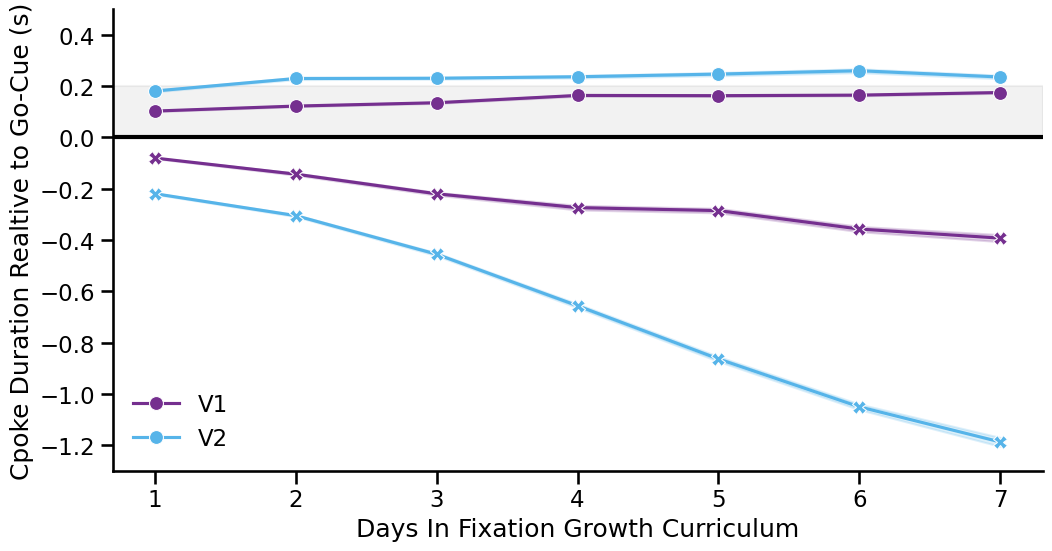

In [8]:
fig, ax = plt.subplots(figsize=(12,6))

sns.despine()
ax.axhline(0, color="black", linewidth=3)

ax.set_ylim(-1.3, 0.5)
sns.lineplot(
    data=valid_g_pdf_7d,
    x="days_relative_to_stage_5_adj",
    y="relative_cpoke_dur",
    ax=ax,
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    marker="o", 
    markersize=10, 
    errorbar="se"
)

sns.lineplot(
    data=violation_g_pdf_7d,
    x="days_relative_to_stage_5_adj",
    y="relative_cpoke_dur",
    ax=ax,
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    marker="X", 
    markersize=10, 
    errorbar="se",
    legend=False
)

ax.axhspan(0, 0.2, color="gray", alpha=0.1, zorder=0)

ax.legend(
    title="",
    frameon=False
)

ax.set(
    xlabel="Days In Fixation Growth Curriculum",
    ylabel="Cpoke Duration Realtive to Go-Cue (s)",
)

c.save_fig(fig, "fig9_cpoke_duration_over_7d")



In [9]:
res = ttest_cpoke_durations_by_day(valid_g_pdf_7d, max_days=7)

Day 1: **SIGNIFICANT**
	t = -21.773, p = 4.257e-100, Bonferroni adj p = 2.980e-99
	V1 size: 2379, V2 size: 2651
Day 2: **SIGNIFICANT**
	t = -22.466, p = 1.818e-105, Bonferroni adj p = 1.273e-104
	V1 size: 2082, V2 size: 2785
Day 3: **SIGNIFICANT**
	t = -21.640, p = 6.159e-99, Bonferroni adj p = 4.312e-98
	V1 size: 2108, V2 size: 2715
Day 4: **SIGNIFICANT**
	t = -12.197, p = 1.374e-33, Bonferroni adj p = 9.617e-33
	V1 size: 1788, V2 size: 2303
Day 5: **SIGNIFICANT**
	t = -11.775, p = 1.952e-31, Bonferroni adj p = 1.366e-30
	V1 size: 2452, V2 size: 2582
Day 6: **SIGNIFICANT**
	t = -11.964, p = 2.704e-32, Bonferroni adj p = 1.893e-31
	V1 size: 2353, V2 size: 2572
Day 7: **SIGNIFICANT**
	t = -7.975, p = 2.222e-15, Bonferroni adj p = 1.556e-14
	V1 size: 2254, V2 size: 2041


# Growing 7 Days


## Progression Over Days


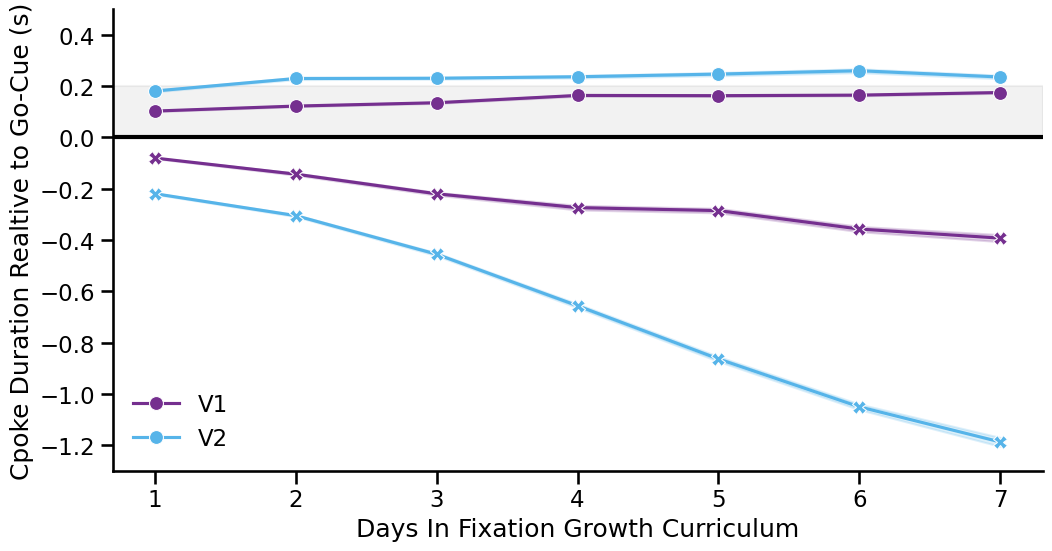

In [207]:
fig, ax = plt.subplots(figsize=(12,6))

sns.despine()
ax.axhline(0, color="black", linewidth=3)

ax.set_ylim(-1.3, 0.5)
sns.lineplot(
    data=valid_g_pdf_7d,
    x="days_relative_to_stage_5_adj",
    y="relative_cpoke_dur",
    ax=ax,
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    marker="o", 
    markersize=10, 
    errorbar="se"
)

sns.lineplot(
    data=violation_g_pdf_7d,
    x="days_relative_to_stage_5_adj",
    y="relative_cpoke_dur",
    ax=ax,
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    marker="X", 
    markersize=10, 
    errorbar="se",
    legend=False
)

ax.axhspan(0, 0.2, color="gray", alpha=0.1, zorder=0)

ax.legend(
    title="",
    frameon=False
)

ax.set(
    xlabel="Days In Fixation Growth Curriculum",
    ylabel="Cpoke Duration Realtive to Go-Cue (s)",
)

c.save_fig(fig, "fig0_cpoke_duration_over_7d")


In [10]:
res = ttest_cpoke_durations_by_day(valid_g_pdf_7d, max_days=7)


Day 1: **SIGNIFICANT**
	t = -21.773, p = 4.257e-100, Bonferroni adj p = 2.980e-99
	V1 size: 2379, V2 size: 2651
Day 2: **SIGNIFICANT**
	t = -22.466, p = 1.818e-105, Bonferroni adj p = 1.273e-104
	V1 size: 2082, V2 size: 2785
Day 3: **SIGNIFICANT**
	t = -21.640, p = 6.159e-99, Bonferroni adj p = 4.312e-98
	V1 size: 2108, V2 size: 2715
Day 4: **SIGNIFICANT**
	t = -12.197, p = 1.374e-33, Bonferroni adj p = 9.617e-33
	V1 size: 1788, V2 size: 2303
Day 5: **SIGNIFICANT**
	t = -11.775, p = 1.952e-31, Bonferroni adj p = 1.366e-30
	V1 size: 2452, V2 size: 2582
Day 6: **SIGNIFICANT**
	t = -11.964, p = 2.704e-32, Bonferroni adj p = 1.893e-31
	V1 size: 2353, V2 size: 2572
Day 7: **SIGNIFICANT**
	t = -7.975, p = 2.222e-15, Bonferroni adj p = 1.556e-14
	V1 size: 2254, V2 size: 2041


In [11]:

res = ttest_cpoke_durations_by_day(violation_g_pdf_7d, max_days=7)

Day 1: **SIGNIFICANT**
	t = 43.737, p = 0.000e+00, Bonferroni adj p = 0.000e+00
	V1 size: 1097, V2 size: 2019
Day 2: **SIGNIFICANT**
	t = 29.034, p = 7.192e-158, Bonferroni adj p = 5.034e-157
	V1 size: 878, V2 size: 1854
Day 3: **SIGNIFICANT**
	t = 29.353, p = 3.443e-163, Bonferroni adj p = 2.410e-162
	V1 size: 906, V2 size: 1957
Day 4: **SIGNIFICANT**
	t = 32.164, p = 2.630e-175, Bonferroni adj p = 1.841e-174
	V1 size: 617, V2 size: 1952
Day 5: **SIGNIFICANT**
	t = 44.634, p = 9.286e-316, Bonferroni adj p = 6.500e-315
	V1 size: 733, V2 size: 2113
Day 6: **SIGNIFICANT**
	t = 45.901, p = 1.621e-321, Bonferroni adj p = 1.134e-320
	V1 size: 653, V2 size: 2311
Day 7: **SIGNIFICANT**
	t = 35.771, p = 2.167e-216, Bonferroni adj p = 1.517e-215
	V1 size: 659, V2 size: 1338


## Histogram


Violation Duration Stats
N violation cpokes: 5543
Mean Violation Duration: -0.23 +/- 0.23 std
Median Violation Duration: -0.14

Valid Duration Stats
N valid cpokes: 15415
Mean Valid Duration: 0.15 +/- 0.12 std
Median Valid Duration: 0.11


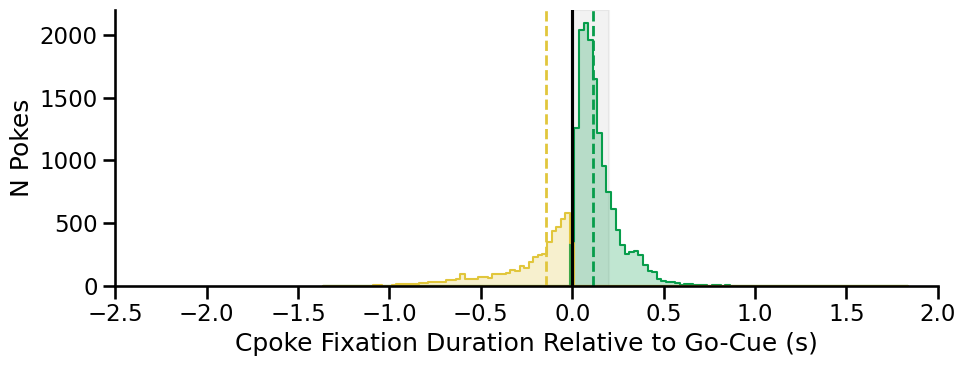

In [12]:
fig, ax = plot_relative_cpoke_dur_histplot(
    g_pdf_7d.query("fix_experiment == 'V1' and fixation_dur < 2"),
    title="",
    element="step",
)

ax.legend().remove()
c.save_fig(fig, "fig9_V1_poke_histogram_growing_stages_7d")

Violation Duration Stats
N violation cpokes: 13199
Mean Violation Duration: -0.64 +/- 0.48 std
Median Violation Duration: -0.52

Valid Duration Stats
N valid cpokes: 17224
Mean Valid Duration: 0.22 +/- 0.18 std
Median Valid Duration: 0.18


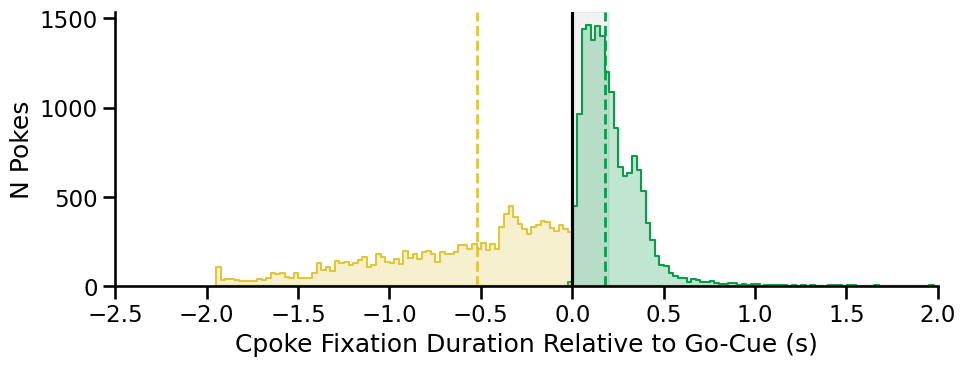

In [14]:
fig, ax = plot_relative_cpoke_dur_histplot(
    g_pdf_7d.query("fix_experiment == 'V2' and fixation_dur < 2"),
    title="",
    element="step",
)

ax.legend().remove()
c.save_fig(fig, "fig9_V2_poke_histogram_growing_stages_7d")

## Avg Violation


In [15]:
g_avg_violation_7d = (
    violation_g_pdf_7d
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          
    .rename('avg_violation_poke_dur')
    .reset_index()
)
stats = g_avg_violation_7d.groupby('fix_experiment').avg_violation_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats

,fix_experiment,median,mean,std,size
0,V1,-0.225,-0.211,0.082,8
1,V2,-0.569,-0.622,0.193,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,5.818844,0.000112


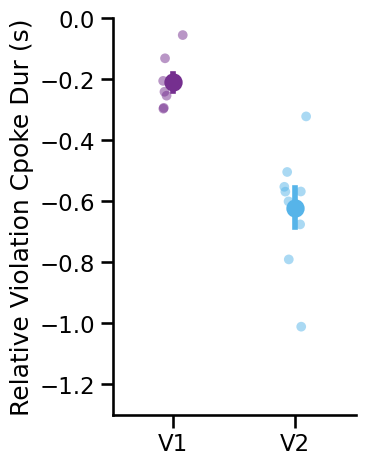

In [16]:
fig, ax = plot_exp_compare_point_strip(g_avg_violation_7d, "avg_violation_poke_dur", "Relative Violation Cpoke Dur (s)", (-1.3, 0))

c.save_fig(fig, "fig9_violation_cpoke_duration_summary_growing_7d")
u.compare_v1_v2(g_avg_violation_7d, "avg_violation_poke_dur")

## Near Cue Violation Rate


In [19]:
g_near_cue_viols_7d = compute_near_cue_violation_rate(violation_g_pdf_7d, window=PRE_GO_VIOLATION_WINDOW)

stats = g_near_cue_viols_7d.groupby('fix_experiment').near_cue_violation_rate.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,59.383,63.767,17.704,8
1,V2,20.627,21.418,9.584,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,6.026263,0.000104


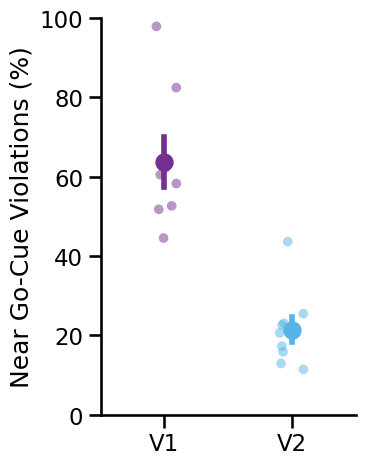

In [20]:
fig, ax = plot_exp_compare_point_strip(g_near_cue_viols_7d, "near_cue_violation_rate", "Near Go-Cue Violations (%)", (0, 100))

c.save_fig(fig, "fig9_near_cue_violation_rate_growing_7d")
u.compare_v1_v2(g_near_cue_viols_7d, "near_cue_violation_rate")

## Avg Valid


In [21]:
g_avg_valid_7d = (
    valid_g_pdf_7d
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          # sample SD; same as pandas default
    .rename('avg_valid_poke_dur')
    .reset_index()
)
stats=g_avg_valid_7d.groupby('fix_experiment').avg_valid_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,0.133,0.140,0.038,8
1,V2,0.207,0.219,0.062,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,-3.234323,0.006286


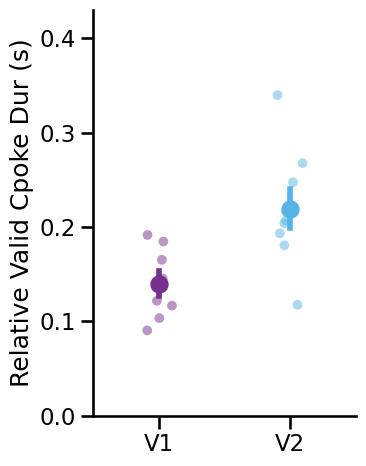

In [22]:
fig, ax = plot_exp_compare_point_strip(g_avg_valid_7d, "avg_valid_poke_dur", "Relative Valid Cpoke Dur (s)", (0, 0.43))


c.save_fig(fig, "fig9_valid_cpoke_duration_summary_growing_7d")
u.compare_v1_v2(g_avg_valid_7d, "avg_valid_poke_dur")

# No warm up


## Histogram


Violation Duration Stats
N violation cpokes: 5302
Mean Violation Duration: -0.24 +/- 0.24 std
Median Violation Duration: -0.15

Valid Duration Stats
N valid cpokes: 14645
Mean Valid Duration: 0.15 +/- 0.12 std
Median Valid Duration: 0.11


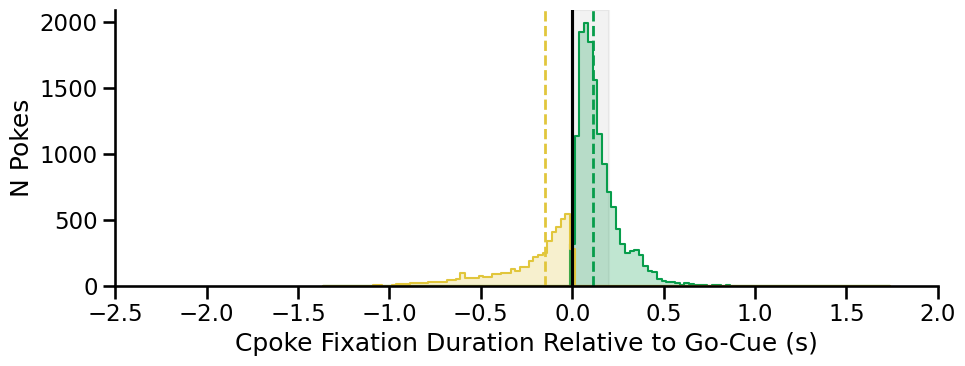

In [23]:
fig, ax = plot_relative_cpoke_dur_histplot(
    no_warm_up_g_pdf_7d_v1.query("fix_experiment == 'V1' and fixation_dur < 2"),
    title="",
    element="step",
)

ax.legend().remove()
c.save_fig(fig, "fig_s5_V1_poke_histogram_no_warm_up_7d")

## Avg Violation


In [24]:
no_warm_up_g_avg_violation_7d = (
    violation_no_warm_up_g_pdf_7d
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          
    .rename('avg_violation_poke_dur')
    .reset_index()
)
stats = no_warm_up_g_avg_violation_7d.groupby('fix_experiment').avg_violation_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats

,fix_experiment,median,mean,std,size
0,V1,-0.229,-0.217,0.085,8
1,V2,-0.569,-0.622,0.193,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,5.708604,0.000125


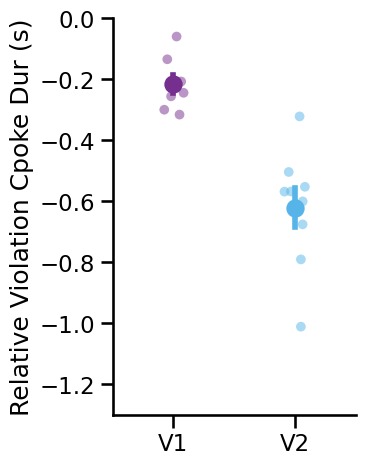

In [26]:
fig, ax = plot_exp_compare_point_strip(no_warm_up_g_avg_violation_7d, "avg_violation_poke_dur", "Relative Violation Cpoke Dur (s)", (-1.3, 0))

c.save_fig(fig, "fig_s5_violation_cpoke_duration_summary_no_warm_up_7d")
u.compare_v1_v2(no_warm_up_g_avg_violation_7d, "avg_violation_poke_dur")

## Near Cue Violation Rate


In [27]:
g_near_cue_viols_no_warm_up_7d = compute_near_cue_violation_rate(violation_no_warm_up_g_pdf_7d, window=PRE_GO_VIOLATION_WINDOW)

stats = g_near_cue_viols_no_warm_up_7d.groupby('fix_experiment').near_cue_violation_rate.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,58.726,63.151,18.831,8
1,V2,20.627,21.418,9.584,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,5.651375,0.000202


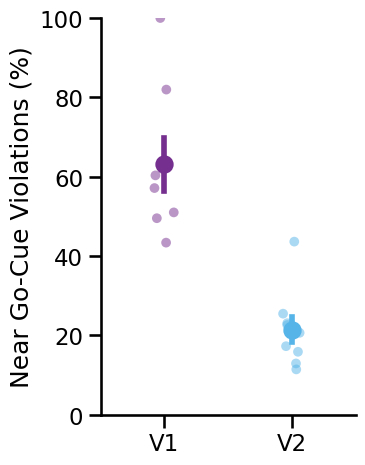

In [28]:
fig, ax = plot_exp_compare_point_strip(g_near_cue_viols_no_warm_up_7d, "near_cue_violation_rate", "Near Go-Cue Violations (%)", (0, 100))

c.save_fig(fig, "fig_s5_near_cue_violation_rate_growing_no_warm_up_7d")
u.compare_v1_v2(g_near_cue_viols_no_warm_up_7d, "near_cue_violation_rate")

## Avg Valid


In [29]:
g_avg_valid_no_warm_up_7d = (
    valid_no_warm_up_g_pdf_7d
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          # sample SD; same as pandas default
    .rename('avg_valid_poke_dur')
    .reset_index()
)
stats=g_avg_valid_no_warm_up_7d.groupby('fix_experiment').avg_valid_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,0.134,0.141,0.039,8
1,V2,0.207,0.219,0.062,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,-3.146881,0.007323


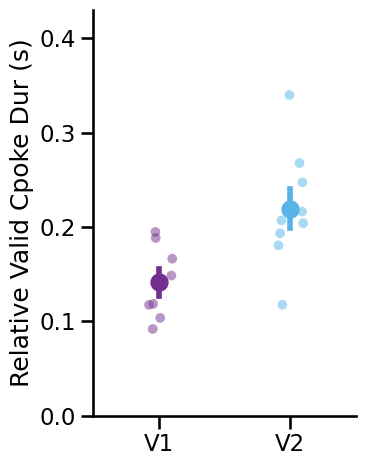

In [30]:
fig, ax = plot_exp_compare_point_strip(g_avg_valid_no_warm_up_7d, "avg_valid_poke_dur", "Relative Valid Cpoke Dur (s)", (0, 0.43))


c.save_fig(fig, "fig_s5_valid_cpoke_duration_summary_no_warm_up_7d")
u.compare_v1_v2(g_avg_valid_no_warm_up_7d, "avg_valid_poke_dur")

# Growing All


## Progression Over Days


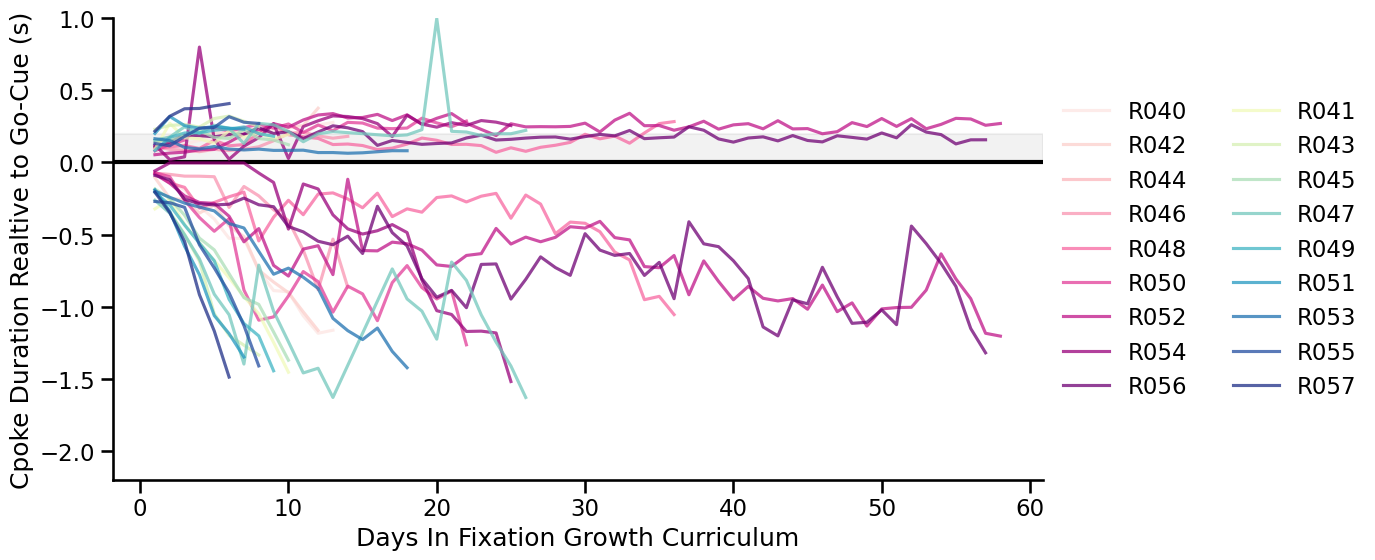

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

sns.despine()
ax.axhline(0, color="black", linewidth=3)

ax.set_ylim(-2.2, 1)

sns.lineplot(
    data=valid_g_pdf.query("fixation_dur < 2"),
    x="days_relative_to_stage_5_adj",
    y="relative_cpoke_dur",
    ax=ax,
    hue="animal_id",
    palette=c.ANIMAL_PALETTE,
    hue_order=c.HUE_ORDER_ANIMALS,
    errorbar=None,
    alpha=0.75,
    legend=True,
)

sns.lineplot(
    data=violation_g_pdf.query("fixation_dur < 2"),
    x="days_relative_to_stage_5_adj",
    y="relative_cpoke_dur",
    ax=ax,
    hue="animal_id",
    palette=c.ANIMAL_PALETTE,
    hue_order=c.HUE_ORDER_ANIMALS,
    errorbar=None,
    alpha=0.75,
    legend=False
)

ax.axhspan(0, 0.2, color="gray", alpha=0.1, zorder=0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    title="",
    frameon=False,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=2
)

ax.set(
    xlabel="Days In Fixation Growth Curriculum",
    ylabel="Cpoke Duration Realtive to Go-Cue (s)",
)

c.save_fig(fig, "fig_s5_cpoke_duration_over_all_days_by_animal")


## Histogram


Violation Duration Stats
N violation cpokes: 16099
Mean Violation Duration: -0.50 +/- 0.45 std
Median Violation Duration: -0.36

Valid Duration Stats
N valid cpokes: 59823
Mean Valid Duration: 0.20 +/- 0.15 std
Median Valid Duration: 0.17


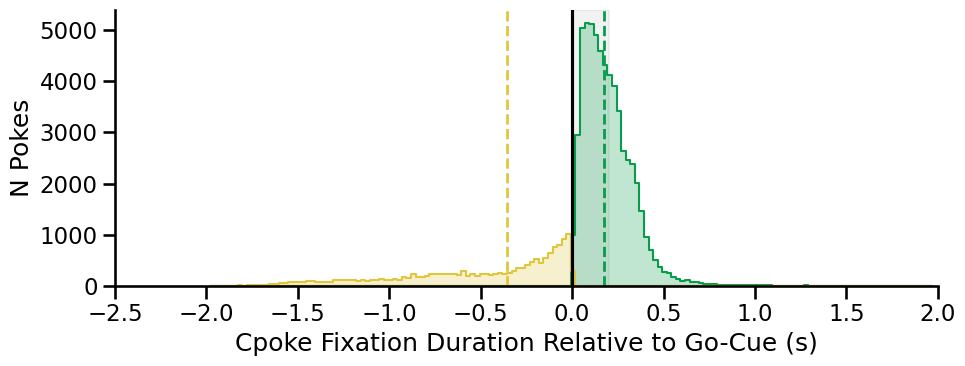

In [32]:
fig, ax = plot_relative_cpoke_dur_histplot(
    g_pdf.query("fix_experiment == 'V1' and fixation_dur < 2"),
    title="",
    element="step",
)

ax.legend().remove()
c.save_fig(fig, "fig_s5_V1_poke_histogram_growing_stages_all")

Violation Duration Stats
N violation cpokes: 19984
Mean Violation Duration: -0.80 +/- 0.56 std
Median Violation Duration: -0.72

Valid Duration Stats
N valid cpokes: 26807
Mean Valid Duration: 0.20 +/- 0.16 std
Median Valid Duration: 0.17


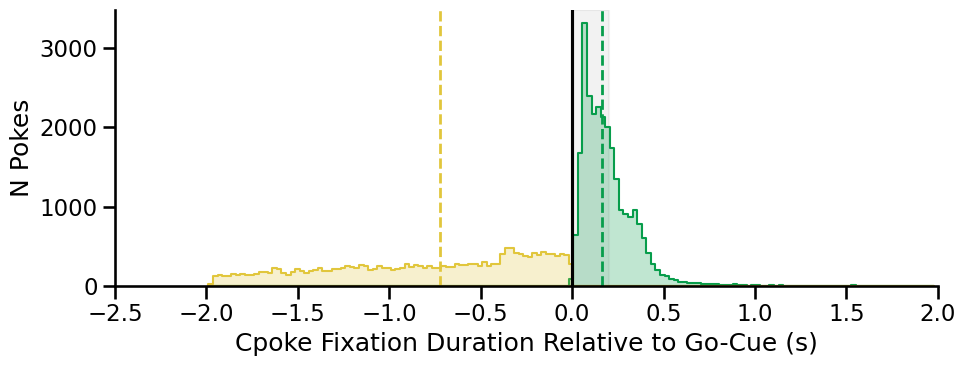

In [175]:
fig, ax = plot_relative_cpoke_dur_histplot(
    g_pdf.query("fix_experiment == 'V2' and fixation_dur < 2"),
    title="",
    element="step",
)

ax.legend().remove()
c.save_fig(fig, "fig_s4_V2_poke_histogram_growing_stages_all")

## Avg Violation


In [33]:
g_avg_violation = (
    violation_g_pdf
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          
    .rename('avg_violation_poke_dur')
    .reset_index()
)
stats = g_avg_violation.groupby('fix_experiment').avg_violation_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats

,fix_experiment,median,mean,std,size
0,V1,-0.551,-0.511,0.145,8
1,V2,-0.898,-0.907,0.144,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,5.652262,0.000049


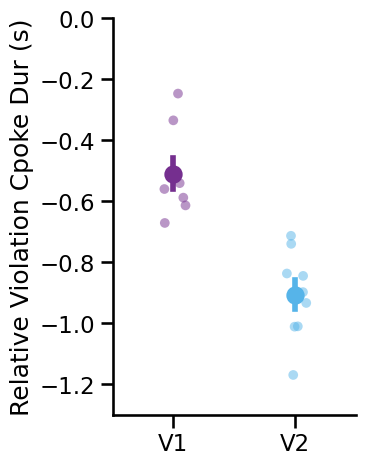

In [34]:
fig, ax = plot_exp_compare_point_strip(g_avg_violation, "avg_violation_poke_dur", "Relative Violation Cpoke Dur (s)", (-1.3, 0))

c.save_fig(fig, "fig_s5_violation_cpoke_duration_summary_growing_all")
u.compare_v1_v2(g_avg_violation, "avg_violation_poke_dur")

## Near Cue Violation Rate


In [36]:
g_near_cue_viols = compute_near_cue_violation_rate(violation_g_pdf, window=PRE_GO_VIOLATION_WINDOW)

stats = g_near_cue_viols.groupby('fix_experiment').near_cue_violation_rate.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,33.399,37.021,13.629,8
1,V2,15.417,14.889,4.553,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,True,8,9,mannwhitney,72.0,0.000082


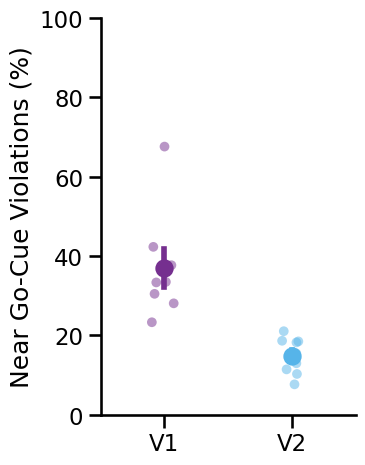

In [37]:
fig, ax = plot_exp_compare_point_strip(g_near_cue_viols, "near_cue_violation_rate", "Near Go-Cue Violations (%)", (0, 100))

c.save_fig(fig, "fig_s5_near_cue_violation_rate_growing_all")
u.compare_v1_v2(g_near_cue_viols, "near_cue_violation_rate")

## Avg Valid


In [38]:
g_avg_valid = (
    valid_g_pdf
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          # sample SD; same as pandas default
    .rename('avg_valid_poke_dur')
    .reset_index()
)
stats=g_avg_valid.groupby('fix_experiment').avg_valid_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,0.192,0.198,0.047,8
1,V2,0.216,0.216,0.068,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,-0.650028,0.52611


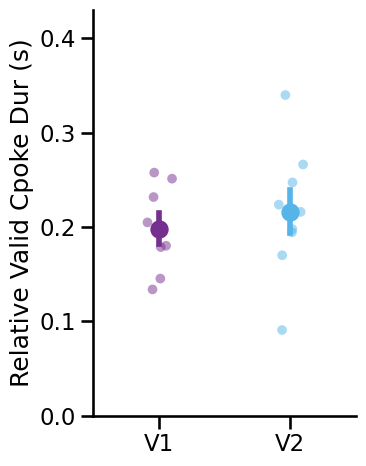

In [39]:
fig, ax = plot_exp_compare_point_strip(g_avg_valid, "avg_valid_poke_dur", "Relative Valid Cpoke Dur (s)", (0, 0.43))


c.save_fig(fig, "fig_s5_valid_cpoke_duration_summary_growing_all")
u.compare_v1_v2(g_avg_valid, "avg_valid_poke_dur")

# Probe


## Histogram


Violation Duration Stats
N violation cpokes: 1172
Mean Violation Duration: -0.80 +/- 0.44 std
Median Violation Duration: -0.82

Valid Duration Stats
N valid cpokes: 9599
Mean Valid Duration: 0.20 +/- 0.13 std
Median Valid Duration: 0.18


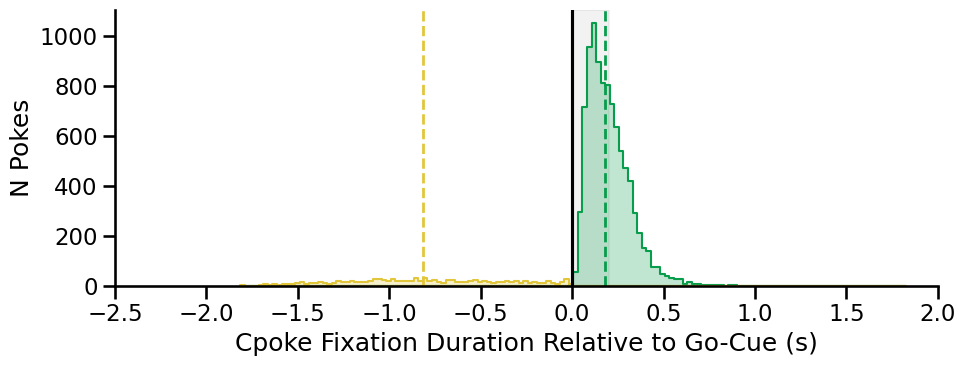

In [40]:
fig, ax = plot_relative_cpoke_dur_histplot(
    pr_pdf.query("fix_experiment == 'V1' and fixation_dur < 2"),
    title="",
    element="step",
)

ax.legend().remove()
c.save_fig(fig, "fig9_V1_poke_histogram_probe_stages")

Violation Duration Stats
N violation cpokes: 1181
Mean Violation Duration: -0.86 +/- 0.44 std
Median Violation Duration: -0.89

Valid Duration Stats
N valid cpokes: 11099
Mean Valid Duration: 0.19 +/- 0.13 std
Median Valid Duration: 0.17


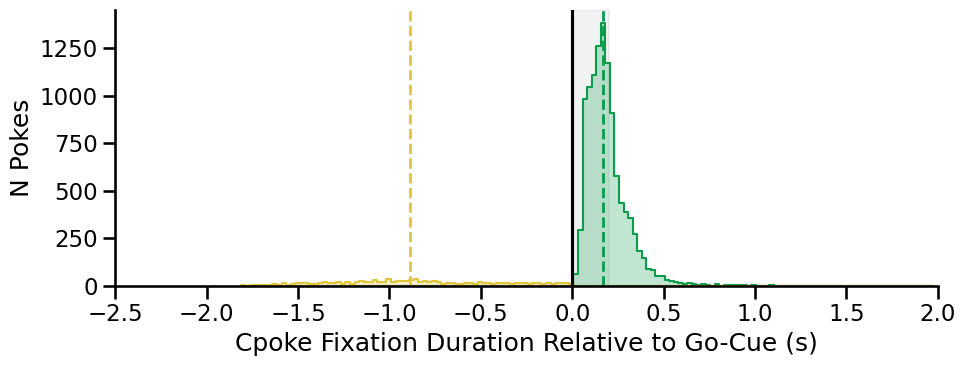

In [41]:
fig, ax = plot_relative_cpoke_dur_histplot(
    pr_pdf.query("fix_experiment == 'V2' and fixation_dur < 2"),
    title="",
    element="step",
)

ax.legend().remove()
c.save_fig(fig, "fig9_V2_poke_histogram_probe_stages")

## Avg Violation


In [42]:
pr_avg_violation = (
    violation_pr_pdf
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          
    .rename('avg_violation_poke_dur')
    .reset_index()
)
stats = pr_avg_violation.groupby('fix_experiment').avg_violation_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats

,fix_experiment,median,mean,std,size
0,V1,-1.010,-1.031,0.070,8
1,V2,-1.008,-1.036,0.116,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,0.114002,0.910936


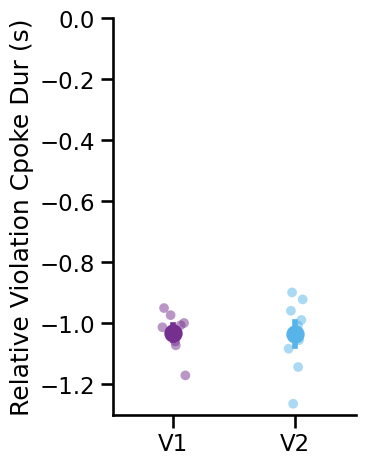

In [43]:
fig, ax = plot_exp_compare_point_strip(pr_avg_violation, "avg_violation_poke_dur", "Relative Violation Cpoke Dur (s)", (-1.3, 0))

c.save_fig(fig, "fig9_violation_cpoke_duration_summary_probe")
u.compare_v1_v2(pr_avg_violation, "avg_violation_poke_dur")

## Near Cue Violation Rate


In [44]:
pr_near_cue_viols = compute_near_cue_violation_rate(violation_pr_pdf, window=PRE_GO_VIOLATION_WINDOW)

stats = pr_near_cue_viols.groupby('fix_experiment').near_cue_violation_rate.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,8.255,8.683,3.036,8
1,V2,8.084,8.476,3.485,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,0.131361,0.897236


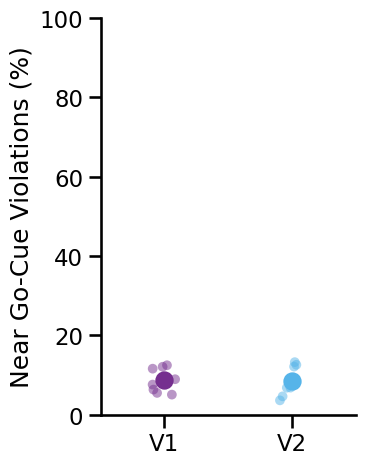

In [45]:
fig, ax = plot_exp_compare_point_strip(pr_near_cue_viols, "near_cue_violation_rate", "Near Go-Cue Violations (%)", (0, 100))

c.save_fig(fig, "fig9_near_cue_violation_rate_probe")
u.compare_v1_v2(pr_near_cue_viols, "near_cue_violation_rate")

## Avg Valid


In [46]:
pr_avg_valid = (
    valid_pr_pdf
    .groupby(['animal_id', 'fix_experiment'])['relative_cpoke_dur']
    .mean()          # sample SD; same as pandas default
    .rename('avg_valid_poke_dur')
    .reset_index()
)
stats=pr_avg_valid.groupby('fix_experiment').avg_valid_poke_dur.agg(
    median=lambda x: round(x.median(), 3),
    mean=lambda x: round(x.mean(), 3),
    std=lambda x: round(x.std(), 3),
    size='size'
).reset_index()
stats


,fix_experiment,median,mean,std,size
0,V1,0.195,0.215,0.041,8
1,V2,0.196,0.196,0.071,9


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,True,8,9,welch_t,0.705023,0.493315


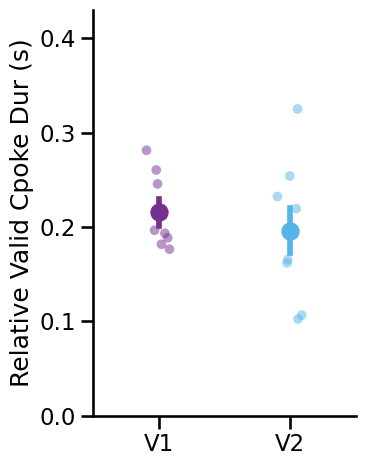

In [48]:
fig, ax = plot_exp_compare_point_strip(pr_avg_valid, "avg_valid_poke_dur", "Relative Valid Cpoke Dur (s)", (0, 0.43))


c.save_fig(fig, "fig9_valid_cpoke_duration_summary_probe")
u.compare_v1_v2(pr_avg_valid, "avg_valid_poke_dur")